<a href="https://colab.research.google.com/github/chandrap08/ml-code/blob/master/CV1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Making a new directory 
!mkdir cifar10

In [2]:

#Downloading the data file 
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
    
    

--2022-08-04 05:16:08--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  31.1MB/s    in 5.5s    

2022-08-04 05:16:14 (29.6 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]



In [3]:
# untar the compressed downloaded files into cifar10 directory
!tar -xvzf cifar-10-python.tar.gz --directory cifar10


cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from os.path import join
from os import listdir
from tqdm import tqdm
import struct as st
from scipy.spatial.distance import cdist
from skimage import img_as_ubyte
from sklearn.metrics import silhouette_score
import numpy.matlib
import copy


In [5]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [6]:
def load_data(data_dir):
    """ The data size is 32x32x3, where each row represents one image in one color (Red, blue, green).
        We unpickle the batch files downloaded. It is in a dictionary format with keys (data, labels).
        for extracting the data we use the data key."""
    
    # Here we initialize train_data with the first batch data as it cannot be empty when we use np.vstack.
    train_data = unpickle(data_dir + '/data_batch_1')[b'data']
    train_labels = unpickle(data_dir + '/data_batch_1')[b'labels']
    
    # Iterate through the remaining batches (2 to 5) and append them to the train_data and train_labels.
    for i in range(2,6):
        #'/data_batch_{i}'.format(i=i)) {Python formating}
        temp = unpickle(data_dir + '/data_batch_{i}'.format(i=i))
        train_data = np.vstack((train_data, temp[b'data']))   
        train_labels += temp[b'labels']
    
    print("train dataset length = {train_data_len}".format(train_data_len=len(train_data)))
    
    test_labels = unpickle(data_dir + "/test_batch")[b'labels']
    test_data = unpickle(data_dir + "/test_batch")[b'data']
    
    print("test data length = {test_data_shape}".format(test_data_shape=len(test_labels)))
    return train_data,train_labels,test_data,test_labels
    
    

In [7]:
data_dir = 'cifar10/cifar-10-batches-py'
train_data,train_labels,test_data,test_labels = load_data(data_dir)

train dataset length = 50000
test data length = 10000


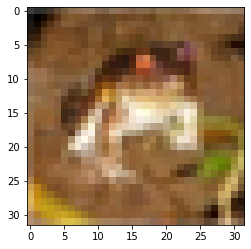

In [8]:
#we are visualising the first image 
data_1_reshaped = np.reshape(train_data[0],(3,32,32)).transpose(1,2,0)
data_1_reshaped
plt.imshow(data_1_reshaped)

In [9]:
def reshape(data):
  # we will now transform the full data set.
  #return np.reshape(data,(3,32,32)).transpose(0,2,3,1)
  return data.reshape(len(data),3,32,32).transpose(0,2,3,1)



In [10]:
reshaped_data = reshape(train_data)

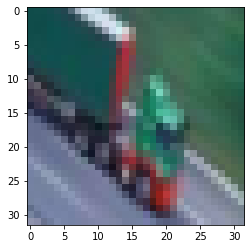

In [11]:
plt.imshow(reshaped_data[50])

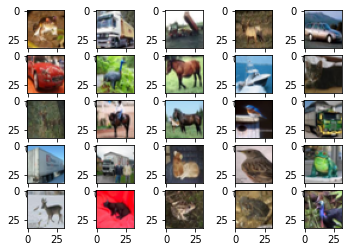

In [12]:
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.imshow(reshaped_data[i])
plt.show()

In [13]:
train_labels[:10]

[6, 9, 9, 4, 1, 1, 2, 7, 8, 3]

In [34]:
n_clusters = 10
max_iter = 500
loss_per_iteration = []

In [36]:
def init_centroids(data):
  np.random.seed(np.random.randint(0,100000))
  centroids = []
  for i in range(n_clusters):
    index = np.random.choice(range(len(data)))
    centroids.append(data[index])
  return centroids

In [17]:
def init_clusters():
  clusters = {'data':{i:[] for i in range(n_clusters)}}
  clusters['labels']={i:[] for i in range(n_clusters)}
  return clusters

In [80]:
def update_centroids(data, clusters, centroids):
  for i in range(n_clusters):
    cluster = clusters['data'][i]
    if cluster == []:
      centroids[i] = data[np.random.choice(range(len(data)))]
    else:
      centroids[i] = np.mean(np.vstack((centroids[i],cluster)),axis=0)
  return centroids

In [55]:
def reshape_cluster(clusters):
  for key,val in list(clusters['data'].items()):
    clusters['data'][key] = np.array(val)
  return clusters

In [28]:
def converged(iteration,centroids,updated_centroids):
  if iteration > max_iter:
    return True
  centroids_dist = np.linalg.norm(np.array(updated_centroids)-np.array(centroids))
  if centroids_dist <= 1e-10:
    print("Converged with distance:",centroids_dist)
    return True
  return False

In [25]:
def calculate_loss(clusters):
  loss = 0
  for key,val in list(clusters['data'].items()):
    if val is not None:
      for v in val:
        loss += np.linalg.norm(v - centroids[key])
        loss_per_iteration.append(loss)
  return loss_per_iteration

In [79]:
def fit(data,labels):
  predicted_labels = [None for _ in range(data.shape[0])]
  centroids = init_centroids(data)
  iterations = 0
  old_centroids = [np.zeros(shape=(data.shape[1],)) for _ in range(n_clusters)]
  while not converged(iterations,old_centroids,centroids):
    old_centroids = copy.deepcopy(centroids)
    clusters = init_clusters()
    for j,sample in tqdm(enumerate(data)):
        min_distance = float('inf')
        for i,centroid in enumerate(centroids):
          #dist = np.linalg.norm(sample-centroid)
          dist = np.linalg.norm(sample - centroid)
          if dist < min_distance:
            min_distance = dist
            predicted_labels[j] = i
    if predicted_labels[j] is not None:
        clusters['data'][predicted_labels[j]].append(sample)                    
        clusters['labels'][predicted_labels[j]].append(labels[j])
        updated_clusters = reshape_cluster(clusters)
        print(updated_clusters.keys())
        updated_centroid = update_centroids(data,updated_clusters,centroids)
        loss_per_iteration = calculate_loss(updated_clusters)
        print("\nIteration:",iterations,'Loss:',loss_per_iteration[-1],'Difference:',centroids_dist)
        iterations+=1
        calculate_accuracy(clusters, predicted_labels)

In [51]:
def calculate_accuracy(clusters, predicted_labels):
  clusters_labels = []
  clusters_info = []
  clusters_accuracy = []
  for cluster,labels in list(clusters['labels'].items()):
    if isinstance(labels[0],(np.ndarray)):
      labels = [l[0] for l in labels]
      occur = 0
      max_label = max(set(labels), key=labels.count)
      clusters_labels.append(max_label)
      for label in labels:
        if label == max_label:
          occur+=1
      accuracy = occur/len(list(labels))
      clusters_info.append([max_label,occur,len(list(labels)),accuracy])
      clusters_accuracy.append(accuracy)
      mean_accuracy = sum(clusters_accuracy)/n_clusters
      labels_ = []
      for i in range(len(predicted_labels)):
        labels_.append(clusters_labels[predicted_labels[i]])
      print('[cluster_label,no_occurence_of_label,total_samples_in_cluster,cluster_accuracy]',clusters_info)
      print('Accuracy:',mean_accuracy)

In [81]:
fit(train_data,train_labels)

50000it [00:04, 10075.60it/s]

dict_keys(['data', 'labels'])



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  after removing the cwd from sys.path.


ValueError: ignored

In [ ]:
###
### k_means_clustering
###

def k_means_clustering(data, no_of_clusters, init_centroids=None, maximum_counter=500, tolerance=1e-9, \
                       print_output=10):  
    """
    Arguments:
      init_centroids - Initialisation for the centroids.
      maximum_counter - Maximum number of iterations.
      tolerance - Tolerance parameter for when the iteration is considered to have converged.
      print_output - A parameter that determines after how many iterations a progress-update is printed.
    Returns:
      centroids - a matrix 𝜇 = (𝜇1..𝜇𝑘) ∈ ℝ𝑘×𝑑  that contains all  𝑘  centroid vectors.
      assignments - a matrix  𝑧 ∈ {0,1}𝑠×𝑘  that contains the cluster assignments for each sample.
    """ 

    N = data.shape[0]
    D = data.shape[1]
    if type(init_centroids).__name__ != "ndarray":
        centroids = np.random.randn(no_of_clusters, D)
    else:
        centroids = init_centroids

    cost = np.Inf
    counter = 0
    sensitivity = np.Inf 

    while (counter < maximum_counter) and (sensitivity > tolerance):
        previous_cost = cost
        distances = cdist(data, centroids)
       
        assignments = np.zeros((N, no_of_clusters))
        assignments[np.arange(N), np.argmin(distances, axis=1)] = 1
       
        denominator = np.matlib.repmat(np.sum(assignments, axis=0), D, 1).T
        tmp_denom = denominator
        tmp_denom[denominator == 0] = 1
        tmp = (assignments.T @ data) / tmp_denom
        centroids[denominator > 0] = tmp[denominator > 0]
        
        cost = np.sum(np.min(distances ** 2, axis=1))
        sensitivity = (previous_cost - cost)/cost
        
        if (((counter + 1) % print_output == 0)):
            print('Iteration [%d/%d], sensitivity: %.4f/%.4f, cost: %.2f' 
                   %(counter+1, maximum_counter, sensitivity, tolerance, cost))
        counter += 1
    
    return centroids, assignments

In [ ]:
centroids, assignments = k_means_clustering(train_data, 10)

Iteration [10/500], sensitivity: 0.0061/0.0000, cost: 403743767270.61
Iteration [20/500], sensitivity: 0.0006/0.0000, cost: 396435089929.75
Iteration [30/500], sensitivity: 0.0001/0.0000, cost: 395730650148.84
Iteration [40/500], sensitivity: 0.0000/0.0000, cost: 395550112954.25
Iteration [50/500], sensitivity: 0.0000/0.0000, cost: 395452550854.20
Iteration [60/500], sensitivity: 0.0000/0.0000, cost: 395402671224.01
Iteration [70/500], sensitivity: 0.0000/0.0000, cost: 395388584419.51
Iteration [80/500], sensitivity: 0.0000/0.0000, cost: 395375604492.69
Iteration [90/500], sensitivity: 0.0000/0.0000, cost: 395365272532.70
Iteration [100/500], sensitivity: 0.0000/0.0000, cost: 395364283877.48


In [ ]:
print(centroids, assignments)

[[174.75510554 174.83713746 176.541445   ...  90.11463875  91.22378582
   92.79440535]
 [ 87.57726002  87.07567568  87.80950606 ...  84.52395154  84.73401678
   85.04082013]
 [205.74093551 204.93855522 205.43454193 ... 181.07583725 181.21920841
  181.99474121]
 ...
 [122.50468412 121.6202258  122.721595   ... 156.84794619 156.1434062
  156.11914485]
 [110.40418895 109.8822044  111.26693405 ...  80.43983957  80.79486037
   81.36571598]
 [192.94876957 192.4360179  193.64541387 ... 116.20559284 117.70134228
  119.58970917]] [[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 1. ... 0. 0. 0.]]


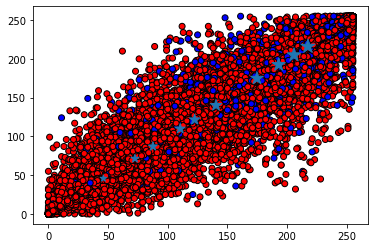

In [ ]:
#we have to now tune the parameters for  better performance,We would have a centroid wit its cluster points clearly defined.

from matplotlib.colors import ListedColormap
colormap_bright = ListedColormap(['#FF0000', '#0000FF'])
plt.scatter(train_data[:, 0], train_data[:, 1], c=assignments[:, 0], cmap=colormap_bright, edgecolors='k')
plt.scatter(centroids[:,0], centroids[:,1], centroids[:,1], marker="*")

In [ ]:
#
#SC = silhouette score

#SC = silhouette_score(train_data, assignments[:,0])

#print('The silhouette score is: %f' % SC)

In [ ]:
  ## which images are assigned to each cluster:
    # 1. check all data points assigned to each cluster
    # 2. check actual labels of the data points assigned to each cluster
    # 3. assign the mode of actual labels to be the label for that cluster
    # We will not use CNN for better performance instead we will focus on Clsutering algorithms and the performance is expected to be low as its a complete unsupervised learning as we won't be using the labels to train our model.

In [ ]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']